# WIP Data augmentation 


In [63]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf


import pathlib
import pandas as pd

import pydicom # for DICOM images
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
print(tf.__version__)

2.6.0


In [64]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [89]:
# Directory
directory = '/Users/renau/Desktop/DATA/data_proj_melanoma'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

# Change columns names
new_names = ['dcm_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

Train has 33,126 rows and Test has 10,982 rows.


In [90]:
# === JPEG ===
# Create the paths
path_train = directory + '/jpeg/train/' + train_df['dcm_name'] + '.jpg'
path_test = directory + '/jpeg/test/' + test_df['dcm_name'] + '.jpg'

# Append to the original dataframes
train_df['path_jpeg'] = path_train
test_df['path_jpeg'] = path_test

In [91]:
malignant_df = train_df[train_df['target'] == 1]
malignant_df.head()

,dcm_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,path_jpeg
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...


In [92]:
benin_df = train_df[train_df['target'] == 0]
benin_df.head()

,dcm_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,path_jpeg
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...


In [93]:
mal_file = malignant_df['path_jpeg'].values
mal_labels = malignant_df['target'].values
mal_train_ds = tf.data.Dataset.from_tensor_slices((mal_file, mal_labels))
len(list(mal_train_ds))

584

In [94]:
ben_file = benin_df['path_jpeg'].values
ben_labels = benin_df['target'].values
ben_train_ds = tf.data.Dataset.from_tensor_slices((ben_file, ben_labels))
len(list(ben_train_ds))

32542

In [95]:
benPart_train_ds = ben_train_ds.take(len(list(mal_train_ds)))
#benPart_train_ds = ben_train_ds.take(15000)
len(list(benPart_train_ds))

584

In [96]:
train_ds = mal_train_ds.concatenate(benPart_train_ds)
#train_ds = ben_train_ds.take(1000)
shuf_train_ds = train_ds.shuffle(len(list(train_ds)))
len(list(shuf_train_ds))

1168

In [97]:
def make_balanced_dataset(ds_class1, ds_class2):
    half_size = min(len(list(ds_class1)),len(list(ds_class2)))
    ds_1 = ds_class1.take(half_size)
    ds_2 = ds_class2.take(half_size)
    ds_full = ds_1.concatenate(ds_2)
    ds_full = ds_full.shuffle(half_size*2, reshuffle_each_iteration=False)
    return ds_full.skip((half_size*2)//5),ds_full.take((half_size*2)//5),
#print(make_balanced_dataset(ben_train_ds,mal_train_ds))   
ds_train, ds_val = make_balanced_dataset(ben_train_ds,mal_train_ds)
size = len(list(ds_val))
print(size, len(list(ds_train)))

233 935


In [98]:
ex_ds = ds_train.take(4)
for element in ex_ds :
    print(element[0].numpy(),'and target: ',element[1].numpy())

b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_0263478.jpg' and target:  0
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_8545949.jpg' and target:  1
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_0182020.jpg' and target:  0
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_6784593.jpg' and target:  1


In [99]:
def read_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, dtype = tf.uint8, expand_animations = False)
    return image, label

ds_train = ds_train.map(read_image)
ds_val = ds_val.map(read_image)

In [100]:
ex_ds = ds_train.take(3)
for element in ex_ds :
    print(element[0].numpy().shape)

(4000, 6000, 3)
(1053, 1872, 3)
(4000, 6000, 3)


In [101]:
def adapt_data(image, label):
    image = tf.image.resize(image, [256,256])
    return image, label

def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float64)
    return image, label
    
ds_train= ds_train.map(adapt_data).map(convert_to_float).batch(32)
ds_val= ds_val.map(adapt_data).map(convert_to_float).batch(32)

ex_ds = ds_train.take(3)
for element in ex_ds :
    print(element[0].shape)
    print(element[1].shape)

(32, 256, 256, 3)
(32,)
(32, 256, 256, 3)
(32,)
(32, 256, 256, 3)
(32,)


In [102]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [103]:
from tensorflow import keras
from tensorflow.keras import layers

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')
])

In [104]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [105]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=150,
)

Epoch 1/150
30/30 [==============================] - 6s 186ms/step - loss: 0.6910 - binary_accuracy: 0.5380 - val_loss: 0.6772 - val_binary_accuracy: 0.6137
Epoch 2/150
30/30 [==============================] - 1s 38ms/step - loss: 0.6667 - binary_accuracy: 0.5936 - val_loss: 0.6644 - val_binary_accuracy: 0.6094
Epoch 3/150
30/30 [==============================] - 1s 36ms/step - loss: 0.6503 - binary_accuracy: 0.6310 - val_loss: 0.6615 - val_binary_accuracy: 0.6137
Epoch 4/150
30/30 [==============================] - 1s 36ms/step - loss: 0.6334 - binary_accuracy: 0.6449 - val_loss: 0.6457 - val_binary_accuracy: 0.6180
Epoch 5/150
30/30 [==============================] - 1s 36ms/step - loss: 0.6140 - binary_accuracy: 0.6727 - val_loss: 0.6130 - val_binary_accuracy: 0.6695
Epoch 6/150
30/30 [==============================] - 1s 36ms/step - loss: 0.5928 - binary_accuracy: 0.6824 - val_loss: 0.5904 - val_binary_accuracy: 0.6910
Epoch 7/150
30/30 [==============================] - 1s 36ms/st

30/30 [==============================] - 1s 36ms/step - loss: 0.1845 - binary_accuracy: 0.9219 - val_loss: 0.6880 - val_binary_accuracy: 0.7425
Epoch 54/150
30/30 [==============================] - 1s 36ms/step - loss: 0.2084 - binary_accuracy: 0.9112 - val_loss: 0.7094 - val_binary_accuracy: 0.7511
Epoch 55/150
30/30 [==============================] - 1s 36ms/step - loss: 0.1958 - binary_accuracy: 0.9230 - val_loss: 0.7002 - val_binary_accuracy: 0.7597
Epoch 56/150
30/30 [==============================] - 1s 36ms/step - loss: 0.1805 - binary_accuracy: 0.9230 - val_loss: 0.6413 - val_binary_accuracy: 0.7382
Epoch 57/150
30/30 [==============================] - 1s 36ms/step - loss: 0.1748 - binary_accuracy: 0.9305 - val_loss: 0.6713 - val_binary_accuracy: 0.7597
Epoch 58/150
30/30 [==============================] - 1s 36ms/step - loss: 0.1591 - binary_accuracy: 0.9433 - val_loss: 0.5909 - val_binary_accuracy: 0.7468
Epoch 59/150
30/30 [==============================] - 1s 36ms/step - lo

30/30 [==============================] - 1s 36ms/step - loss: 0.0053 - binary_accuracy: 1.0000 - val_loss: 1.2034 - val_binary_accuracy: 0.7382
Epoch 106/150
30/30 [==============================] - 1s 36ms/step - loss: 0.0070 - binary_accuracy: 1.0000 - val_loss: 1.1684 - val_binary_accuracy: 0.7511
Epoch 107/150
30/30 [==============================] - 1s 36ms/step - loss: 0.0062 - binary_accuracy: 0.9979 - val_loss: 1.2995 - val_binary_accuracy: 0.7511
Epoch 108/150
30/30 [==============================] - 1s 36ms/step - loss: 0.0044 - binary_accuracy: 1.0000 - val_loss: 1.1933 - val_binary_accuracy: 0.7511
Epoch 109/150
30/30 [==============================] - 1s 36ms/step - loss: 0.0133 - binary_accuracy: 0.9947 - val_loss: 1.5188 - val_binary_accuracy: 0.7382
Epoch 110/150
30/30 [==============================] - 1s 36ms/step - loss: 0.0252 - binary_accuracy: 0.9914 - val_loss: 1.2101 - val_binary_accuracy: 0.7682
Epoch 111/150
30/30 [==============================] - 1s 36ms/ste

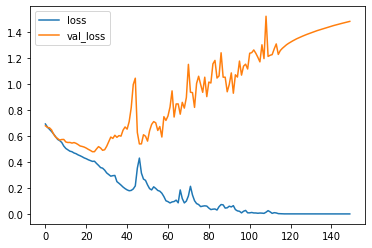

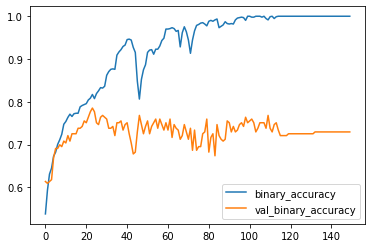

In [106]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [107]:
predictions = model.predict(ds_train)

b =0
m = 0
u = 0
for element in predictions :
    if(element[0] > 0.95) :
        m +=1
    elif(element[0]< 0.05) :
        b +=1
    else :
        u +=1
        
print("Prédictions ;\n - Malin(s): ", m, "\n - Bénins: ", b, "\n - doutes: ", u, "\n - Totale comp: ", b+u+m," vs ",len(predictions))

Prédictions ;
 - Malin(s):  467 
 - Bénins:  468 
 - doutes:  0 
 - Totale comp:  935  vs  935


In [112]:
predictions = model.predict(ds_val)

b =0
m = 0
for element in predictions :
    if(element[0] > 0.5) :
        m +=1
    elif(element[0]< 0.5) :
        b +=1
        
print("Prédictions ;\n - Malin(s): ", m, "\n - Bénins: ", b, "\n - Totale comp: ", b+u+m," vs ",len(predictions))

Prédictions ;
 - Malin(s):  120 
 - Bénins:  113 
 - Totale comp:  233  vs  233


In [109]:
from sklearn.metrics import plot_confusion_matrix  

def predict_class_label_number(dataset):
    predictions =  model.predict(dataset)
    res = np.zeros(len(predictions))
    i = 0 
    for element in predictions : 
        if(element[0]> 0.5):
            res[i] = 1
        i += 1
    return tf.convert_to_tensor(res)

def give_labels (dataset, size):
    lab = np.zeros(size)
    i = 0
    for batch in dataset:
        for element in batch[1] :
            lab[i] = element.numpy()
            i +=1
    return tf.convert_to_tensor(lab)
    
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(5,5))
    plt.imshow(cm)
    plt.colorbar()
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

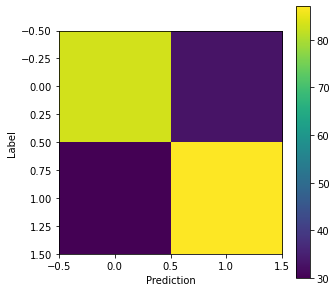

In [110]:
dataset = ds_val
#size = define upper bcs easier
confusion_mtx = tf.math.confusion_matrix(
    give_labels(dataset, size),
    predict_class_label_number(dataset),
    num_classes=2)
show_confusion_matrix(confusion_mtx, [0,1])